<div >
<img src = "../banner.jpg" />
</div>

<a target="_blank" href="https://colab.research.google.com/github/ignaciomsarmiento/BDML_202501/blob/main/Modulo05/CuadernoModulo05_ArbolesBosques.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Tree-Based Methods

## Motivación: Prediciendo Precios de propiedades


$$
Precio=f(Habitaciones,DCBD)
$$



## CARTs

Cargamos los paquetes

In [ ]:
# install.packages("pacman") #run this line if you use Google Colab

In [1]:
#packages
require("pacman")
p_load("tidyverse","ggplot2")

Loading required package: pacman



### Toy example

In [2]:
db<-read.csv('https://raw.githubusercontent.com/ignaciomsarmiento/datasets/main/toy_houses.csv')

In [3]:
dim(db)

[1] 1000    3

In [4]:
head(db)

,price,habitaciones,DCBD
,<dbl>,<int>,<dbl>
1,162753.09,3,1.190307
2,73131.30,0,1.910839
3,162757.45,2,1.227716
4,73127.75,1,1.824990
5,73128.71,0,1.915576
6,98715.60,3,1.505208


In [5]:
summary(db)

     price         habitaciones        DCBD      
 Min.   : 73122   Min.   :0.000   Min.   :1.001  
 1st Qu.: 73133   1st Qu.:1.000   1st Qu.:1.257  
 Median :162749   Median :2.000   Median :1.485  
 Mean   :123534   Mean   :1.993   Mean   :1.498  
 3rd Qu.:162755   3rd Qu.:3.000   3rd Qu.:1.749  
 Max.   :162764   Max.   :8.000   Max.   :2.000  

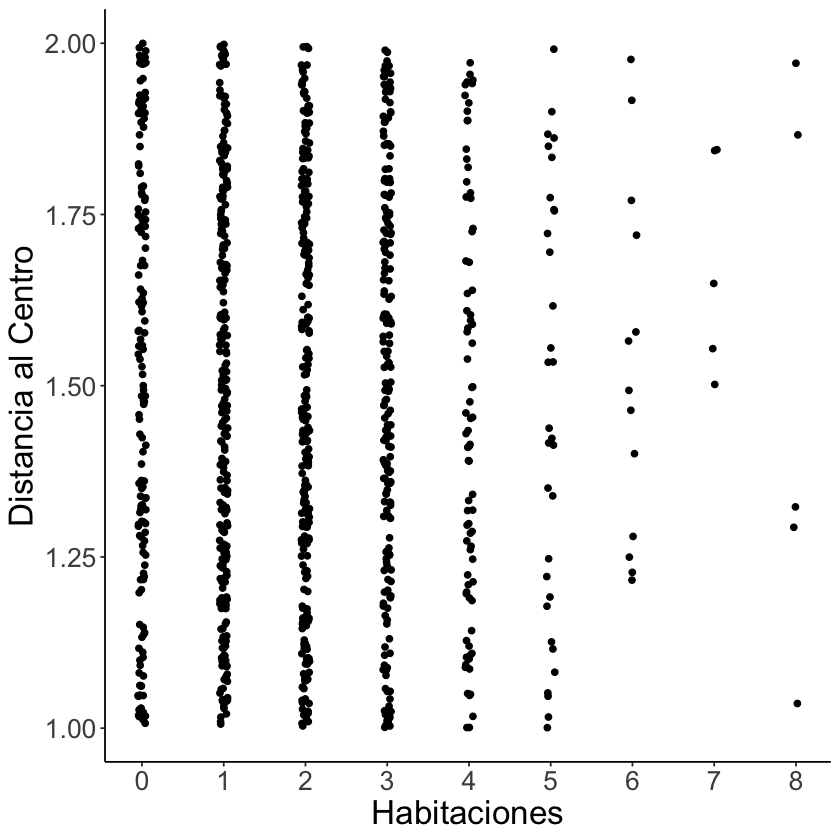

In [6]:
ggplot(db) +
  geom_point(aes(x=habitaciones,y=DCBD),position=position_jitter(width = .05)) +
  scale_x_continuous(breaks=seq(0,8,1)) +
  theme_classic() +
  xlab("Habitaciones") +
  ylab("Distancia al Centro") +
  theme(legend.position =  "none",
      text=element_text(size=20))

#### Algorithm


-  Datos: $y_{n\times 1}$  y $X_{n\times k}$ 

-  Definiciones

      -  *j* es la variable que parte el espacio 
      - *s* es el punto de partición


-  Definimos los siguientes semiplanos

\begin{align}
R_1(j,s)=\{X|X_j\leq s\} \,\,\, \& \,\,\, R_2(j,s)=\{X|X_j > s\}
\end{align}

-  *El problema*: buscar la variable de partición $X_j$ y el punto $s$ de forma tal que 


\begin{align}
\underset{j,s}{min} \left[ \underset{y_{R_1}}{min}\sum_{x_i\in R_1(j,s)}(y-y_{R_1})^2+ \underset{y_{R_2}}{min}\sum_{x_i\in R_2(j,s)}(y-y_{R_2})^2\right]
\end{align}



#### Algorithm by hand ("artesanal")

1. Iniciemos por DBCD

In [7]:
MSE_dbcd<-NA

j<-1
for(i in seq(1.25,1.75,0.25)){
    #Region 1
  R1<- db %>% filter(DCBD<=i)
  R1<- R1 %>% mutate(yR1=mean(price))
  MSEr1<- sum((R1$price-R1$yR1)^2)
 #Region 2
  R2<- db %>% filter(DCBD>i)
  R2<- R2 %>% mutate(yR2=mean(price))
  MSEr2<- sum((R2$price-R2$yR2)^2)
  
  MSE_dbcd[j]<-MSEr1+MSEr2
  j<-j+1
}

MSE_dbcd

[1] 1.230580e+12 6.982084e+10 1.138994e+12

2. Luego por Habitaciones

In [8]:
MSE_hab<-NA

for(i in 0:7){
  R1<- db %>% filter(habitaciones<=i)
  R1<- R1 %>% mutate(yR1=mean(price))
  MSEr1<- sum((R1$price-R1$yR1)^2)
  R2<- db %>% filter(habitaciones>i)
  R2<- R2 %>% mutate(yR2=mean(price))
  MSEr2<- sum((R2$price-R2$yR2)^2)
  
  MSE_hab[i+1]<-MSEr1+MSEr2
  
}
MSE_hab

[1] 1.705787e+12 1.693290e+12 1.679039e+12 1.698272e+12 1.713787e+12
[6] 1.716122e+12 1.716019e+12 1.715407e+12

**Mínimo?**

In [10]:
MSE<-c(MSE_dbcd,MSE_hab)
MSE[which.min(MSE)]


[1] 69820839179

#### Algorithm with `rpart`

Sin embargo, no construimos el árbol a mano, usamos el paquete `rpart`, que implementa el algoritmo de árboles de decisión para regresión y clasificación. Este paquete permite ajustar modelos de manera rápida y sencilla:

In [11]:
p_load("rpart")
mytree <- rpart(price~DCBD+habitaciones,data=db)

In [12]:
mytree

n= 1000 

node), split, n, deviance, yval
      * denotes terminal node

1) root 1000 1.716337e+12 123534.30  
  2) DCBD>=1.499274 483 6.982083e+10  81553.15  
    4) habitaciones< 2.5 324 3.060291e+03  73130.58 *
    5) habitaciones>=2.5 159 1.696944e+03  98716.14 *
  3) DCBD< 1.499274 517 4.730729e+03 162754.70 *

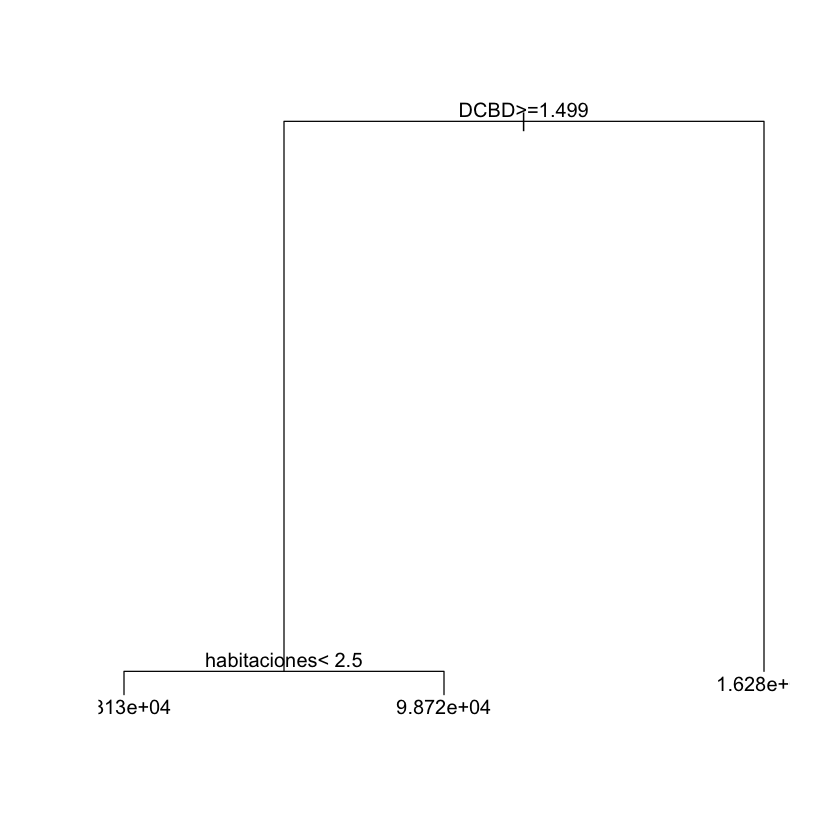

In [13]:
plot(mytree)
text(mytree)

Para visualizar árboles de decisión de forma mas "bonita", podemos usar el paquete `rpart.plot`, que extiende las capacidades de rpart con funciones gráficas más potentes y estéticas. La función principal es `prp()` qye permite crear gráficos detallados del árbol entrenado. En el siguiente ejemplo, usamos varias opciones para mejorar la presentación del árbol:

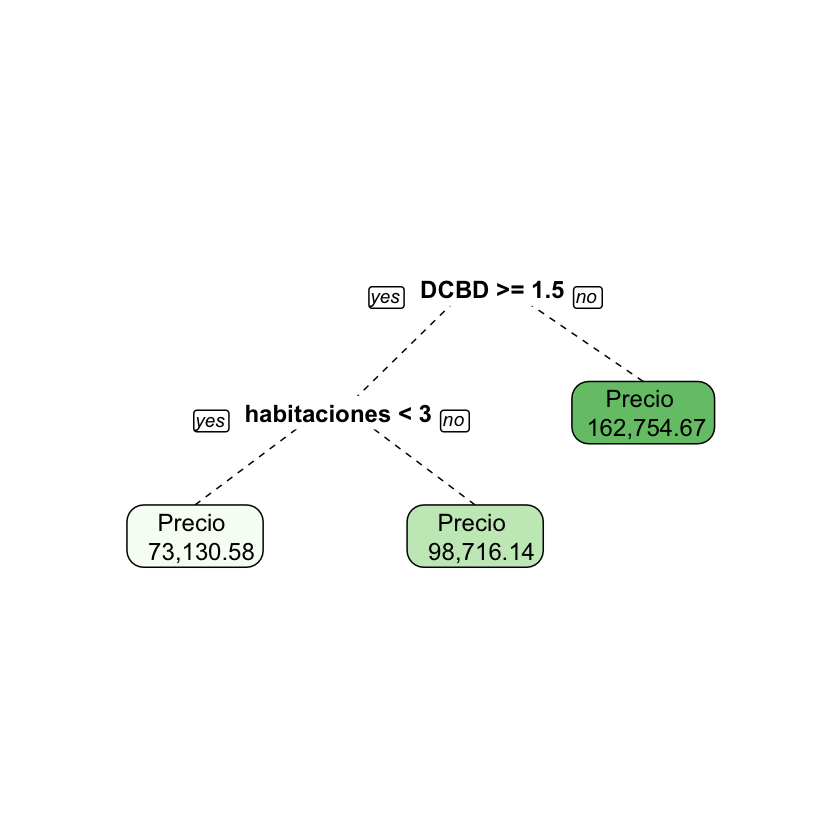

In [14]:
p_load("rpart.plot")

prp(mytree, 
    under = TRUE,              # Muestra información adicional debajo del nodo
    branch.lty = 2,            # Estilo de línea punteada para las ramas
    yesno = 2,                 # Muestra "sí/no" en las bifurcaciones
    faclen = 0,                # Muestra etiquetas completas de factores
    varlen = 15,               # Longitud máxima del nombre de la variable
    tweak = 1.2,               # Ajusta el tamaño del texto
    clip.facs = TRUE,          # Recorta niveles largos de factores
    box.palette = "Greens",    # Paleta de colores para las cajas
    compress = TRUE,           # Comprime el árbol verticalmente
    ycompress = TRUE,          # Comprime también el eje y
    node.fun = function(x, labs, digits, varlen) 
      paste("Precio \n", format(round(mytree$frame$yval, 2), nsmall=0, big.mark=","))  # Personaliza el texto del nodo
)


Recordemos que la forma general del arbol es
$$
f(x_{i};\{R_{j},\gamma_{j}\}_{1}^{J})=\sum_{j=1}^{J}\gamma_{j}I(x\in R_{j})
$$

Entonces en este caso, el precio predicho por el  árbol es 

\begin{align}
\hat{Precio} = 162,754.67 I(DCBD<1.5) + 98,716.14 I(DCBD>=1.5 \& habitaciones>=3) + 73,130.58 I(DCBD>=1.5 \& habitaciones<3) 
\end{align}

### Ames Data Set

Este conjunto de datos contiene información detallada sobre las características de viviendas en Ames, Iowa, y su precio de venta. Incluye más de 80 variables que describen aspectos físicos, de ubicación y de calidad de las propiedades, como el tamaño habitable, el tipo de edificio, el año de construcción, el número de baños, y si tiene garaje o cercado, entre otros.

Es ampliamente utilizado en ciencia de datos y machine learning como un caso realista para problemas de regresión.  
La descripción completa de las variables puede consultarse aquí:  
https://jse.amstat.org/v19n3/decock/DataDocumentation.txt



In [15]:
p_load("modeldata")

data("ames", package = "modeldata")

In [16]:
dim(ames)

[1] 2930   74

In [17]:
head(ames)

MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,⋯,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Sale_Price,Longitude,Latitude
<fct>,<fct>,<dbl>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<int>,<int>,<int>,<fct>,<fct>,<int>,<dbl>,<dbl>
One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141,31770,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,⋯,No_Fence,None,0,5,2010,WD,Normal,215000,-93.61975,42.05403
One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80,11622,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,⋯,Minimum_Privacy,None,0,6,2010,WD,Normal,105000,-93.61976,42.05301
One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81,14267,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,⋯,No_Fence,Gar2,12500,6,2010,WD,Normal,172000,-93.61939,42.05266
One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93,11160,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,⋯,No_Fence,None,0,4,2010,WD,Normal,244000,-93.61732,42.05125
Two_Story_1946_and_Newer,Residential_Low_Density,74,13830,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,⋯,Minimum_Privacy,None,0,3,2010,WD,Normal,189900,-93.63893,42.06090
Two_Story_1946_and_Newer,Residential_Low_Density,78,9978,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,⋯,No_Fence,None,0,6,2010,WD,Normal,195500,-93.63893,42.06078


In [39]:
amestree <- rpart(log(Sale_Price) ~  Gr_Liv_Area  + Bldg_Type + Fence + Lot_Area,data=ames, control = list(maxdepth =2 ))


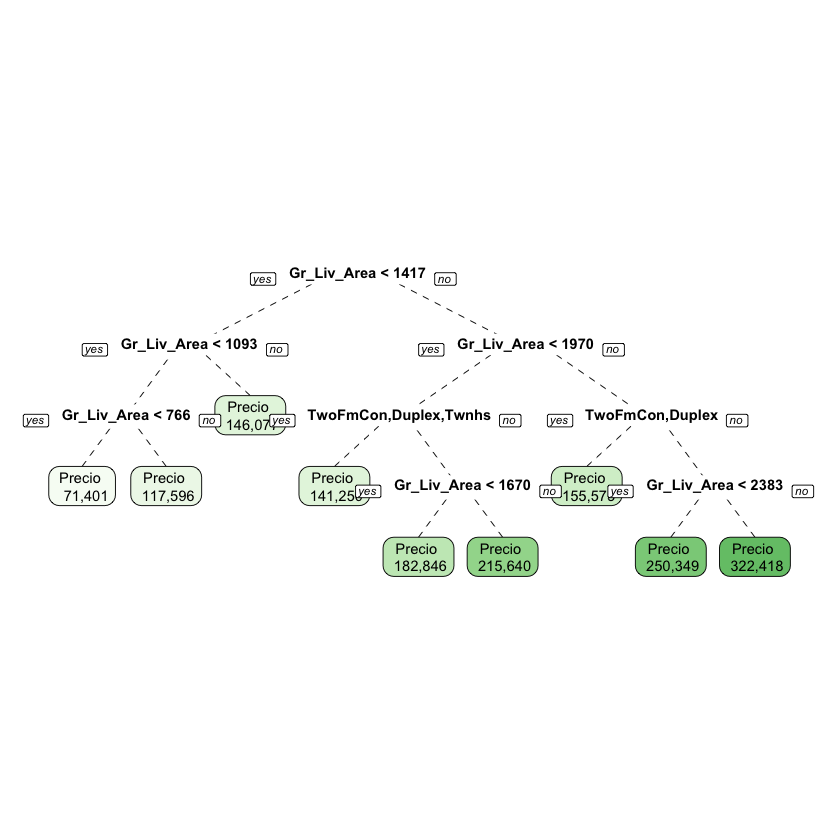

In [25]:

p_load("rpart.plot")
prp(amestree, under = TRUE, branch.lty = 2, yesno = 2, faclen = 0, varlen=15,tweak=1.2,clip.facs= TRUE,box.palette = "Greens",compress=FALSE,ycompress = FALSE,node.fun=function(x, labs, digits, varlen) paste("Precio \n", format(round(exp(amestree$frame$yval), 0), nsmall=0, big.mark=",")))

### Sobreajuste

<div >
<img src = "figures/tree_uba.png" width="300"/>
</div>


- Fijar la profundidad del árbol. (implementado en Caret `method=rpart2`)

- Fijar la mínima cantidad de datos que están contenidos dentro de cada hoja. 

- Cost complexity pruning (implementado en Caret con `method=rpart`)

- `tidymodels` implementa todos

##### Implementación con Caret

In [26]:
p_load("caret")

In [27]:
fitControl<-trainControl(method ="cv",
                         number=5)

#####  `method=rpart2`  allows to tune Max Tree Depth

In [28]:
set.seed(123)
tree_rpart2 <- train(
    log(Sale_Price) ~ Gr_Liv_Area  + Bldg_Type + Fence + Lot_Area,
    data=ames,
    method = "rpart2",
    trControl = fitControl,
    tuneGrid = expand.grid(maxdepth = seq(1,8,1))
)

In [29]:
tree_rpart2

CART 

2930 samples
   4 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 2344, 2345, 2344, 2343, 2344 
Resampling results across tuning parameters:

  maxdepth  RMSE       Rsquared   MAE      
  1         0.3307490  0.3412068  0.2506236
  2         0.3129377  0.4108913  0.2357003
  3         0.3012935  0.4554833  0.2280263
  4         0.2969431  0.4715011  0.2243649
  5         0.2940238  0.4816534  0.2225891
  6         0.2893923  0.4977432  0.2187853
  7         0.2848199  0.5137234  0.2150838
  8         0.2836619  0.5176284  0.2141427

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was maxdepth = 8.

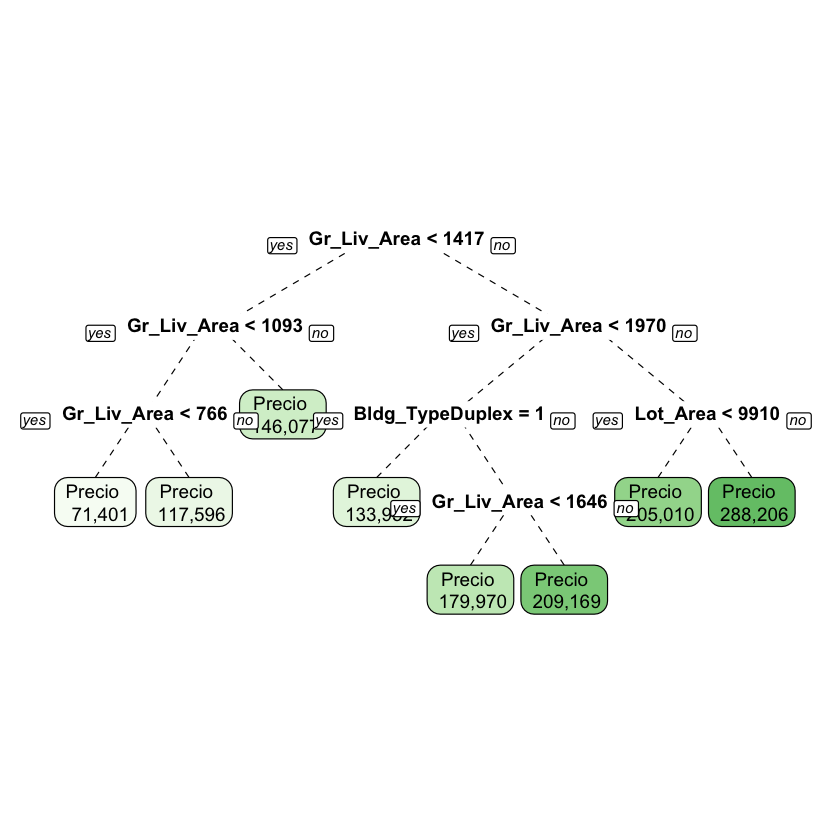

In [30]:
prp(tree_rpart2$finalModel, under = TRUE, branch.lty = 2, yesno = 2, faclen = 0, varlen=15,tweak=1.2,clip.facs= TRUE,box.palette = "Greens",compress=FALSE,ycompress = FALSE,node.fun=function(x, labs, digits, varlen) paste("Precio \n", format(round(exp(tree_rpart2$finalModel$frame$yval), 0), nsmall=0, big.mark=",")))

#### Cost complexity Prunning


Cost complexity del árbol  $T$ con $[T]$ nodos terminales del árbol 
\begin{align}
  C_{\alpha}(T)= \sum_{m=1}^{[T]}  \sum_{x_i\in R_m} (y_i-\hat{y}_m)^2 + \alpha [T]
\end{align}


Objetivo: para un dado $\alpha$, encontrar el pruning óptimo que minimice  $C_{\alpha}(T)$

Se logra eliminando sucesivamente las ramas que producen un aumento mínimo en $\sum_{x_i\in R_m} (y_i-\hat{y}_m)^2 $


##### Algoritmo completo

  - Hacemos crecer el árbol

  - Para un dado $\alpha$, aplicamos  *cost complexity pruning* 
    
  - Utilizamos K-fold cross-validation para elegir $\alpha$. 

  
Tenemos entonces una secuencia de subarboles para distintos valores de $\alpha$ 

Elegimos el $\alpha$ y el subárbol que tienen el menor error de predicción.

#####  `method=rpart`  only allows to tune Complexity Parameter

- Can change the length


In [31]:
set.seed(123)
tree_lenght <- train(
    log(Sale_Price) ~ Gr_Liv_Area  + Bldg_Type + Fence + Lot_Area,
    data=ames,
    method = "rpart",
    trControl = fitControl,
    tuneLength=20
)

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


In [32]:
tree_lenght

CART 

2930 samples
   4 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 2344, 2345, 2344, 2343, 2344 
Resampling results across tuning parameters:

  cp           RMSE       Rsquared   MAE      
  0.002663317  0.2638306  0.5833696  0.1951839
  0.002928339  0.2639011  0.5830236  0.1952403
  0.003041636  0.2649449  0.5798166  0.1959880
  0.003465082  0.2659967  0.5766074  0.1974884
  0.003602553  0.2663203  0.5754987  0.1979051
  0.004342771  0.2706438  0.5615014  0.2015746
  0.004494195  0.2710421  0.5602756  0.2019178
  0.005388410  0.2760364  0.5438482  0.2065736
  0.005580504  0.2760364  0.5438482  0.2065736
  0.006812401  0.2788874  0.5339517  0.2098885
  0.008018890  0.2806451  0.5278070  0.2114909
  0.009010266  0.2832222  0.5189590  0.2138051
  0.009277384  0.2832222  0.5189590  0.2138051
  0.012132238  0.2874601  0.5046112  0.2169528
  0.014271840  0.2903955  0.4943203  0.2198354
  0.018477494  0.2970067  0.4712615  0.2249536
  0.0258

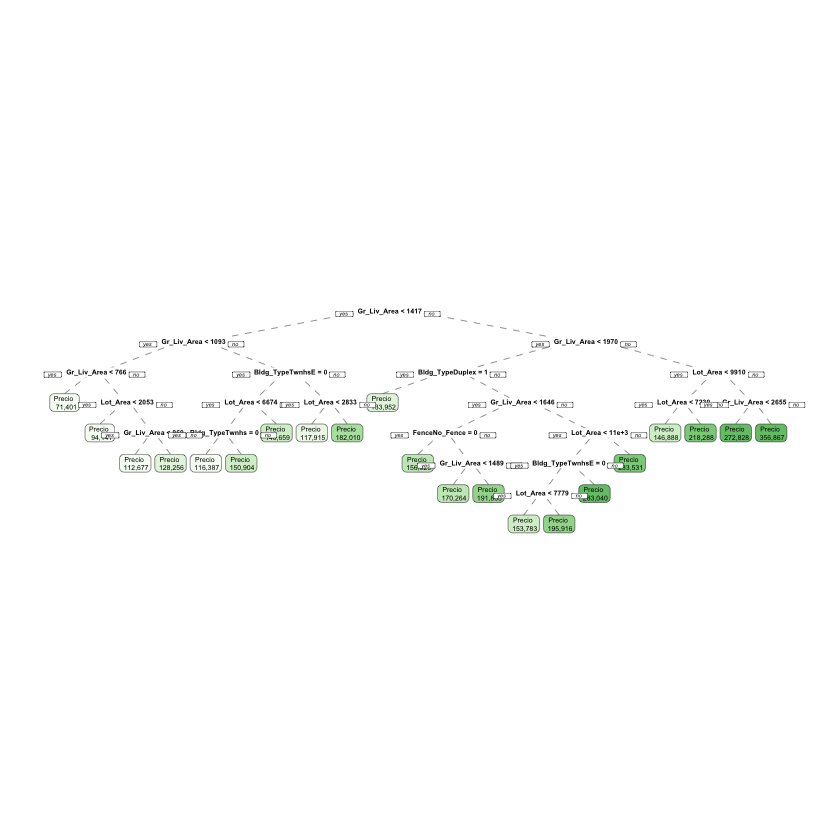

In [36]:
prp(tree_lenght$finalModel, under = TRUE, branch.lty = 2, yesno = 2, faclen = 0, varlen=15,tweak=1.2,clip.facs= TRUE,box.palette = "Greens",compress=FALSE,ycompress = FALSE,node.fun=function(x, labs, digits, varlen) paste("Precio \n", format(round(exp(tree_lenght$finalModel$frame$yval), 0), nsmall=0, big.mark=",")))

- Or the grid

In [33]:
set.seed(123)
tree_grid <- train(
    log(Sale_Price) ~ Gr_Liv_Area  + Bldg_Type + Fence + Lot_Area,
    data=ames,
    method = "rpart",
    trControl = fitControl,
    tuneGrid = expand.grid(cp = seq(0.001707763, 0.001707765, length.out = 100))
)


In [34]:
tree_grid

CART 

2930 samples
   4 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 2344, 2345, 2344, 2343, 2344 
Resampling results across tuning parameters:

  cp           RMSE       Rsquared   MAE      
  0.001707763  0.2604854  0.5943749  0.1916694
  0.001707763  0.2604854  0.5943749  0.1916694
  0.001707763  0.2604854  0.5943749  0.1916694
  0.001707763  0.2604854  0.5943749  0.1916694
  0.001707763  0.2604854  0.5943749  0.1916694
  0.001707763  0.2604854  0.5943749  0.1916694
  0.001707763  0.2604854  0.5943749  0.1916694
  0.001707763  0.2604854  0.5943749  0.1916694
  0.001707763  0.2604854  0.5943749  0.1916694
  0.001707763  0.2604854  0.5943749  0.1916694
  0.001707763  0.2604854  0.5943749  0.1916694
  0.001707763  0.2604854  0.5943749  0.1916694
  0.001707763  0.2604854  0.5943749  0.1916694
  0.001707763  0.2604854  0.5943749  0.1916694
  0.001707763  0.2604854  0.5943749  0.1916694
  0.001707763  0.2604854  0.5943749  0.1916694
  0.0017

More details here: https://topepo.github.io/caret/train-models-by-tag.html#tree-based-model

### Comentarios sobre Árboles


#### Pros: 
  
    - Los árboles son muy fáciles de explicar a las personas (probablemente incluso más fáciles que la regresión lineal)

    - Los árboles se pueden trazar gráficamente y son fácilmente interpretados incluso por no expertos. Variables más importantes en la parte superior



#### Cons:
    
    - Si la estructura es lineal, CART no funciona bien
    
<div >
<img src = "figures/tree_vs_reg.png" />
</div>


    - Los árboles no son muy robustos 
    

## Bagging and Random Forests

### Intuición con código


Una forma de mejorar la estabilidad y precisión de los árboles de decisión es a través del bagging (bootstrap aggregating). La idea central es entrenar múltiples árboles sobre distintas muestras del conjunto de datos —obtenidas con reemplazo (bootstrap)— y luego combinar sus predicciones. Esto reduce la varianza del modelo y mejora su capacidad de generalización.

En este ejemplo, generamos una única muestra bootstrap del dataset original y entrenamos un árbol simple sobre esa muestra:

In [37]:
set.seed(101010)
sample_ames2 <- sample_frac(ames, size = 1, replace = TRUE) 

Entrenamos un árbol poco profundo (maxdepth = 2) para facilitar la visualización y destacar cómo el modelo aprende patrones sobre una muestra específica del conjunto. 

In [38]:
amestree2 <- rpart(log(Sale_Price) ~ Gr_Liv_Area + Bldg_Type + Fence + Lot_Area,
                   data = sample_ames2,
                   control = list(maxdepth = 2))

Luego, visualizamos el árbol con `prp()` personalizando las etiquetas de los nodos para mostrar el precio estimado en escala original (deshaciendo el log):

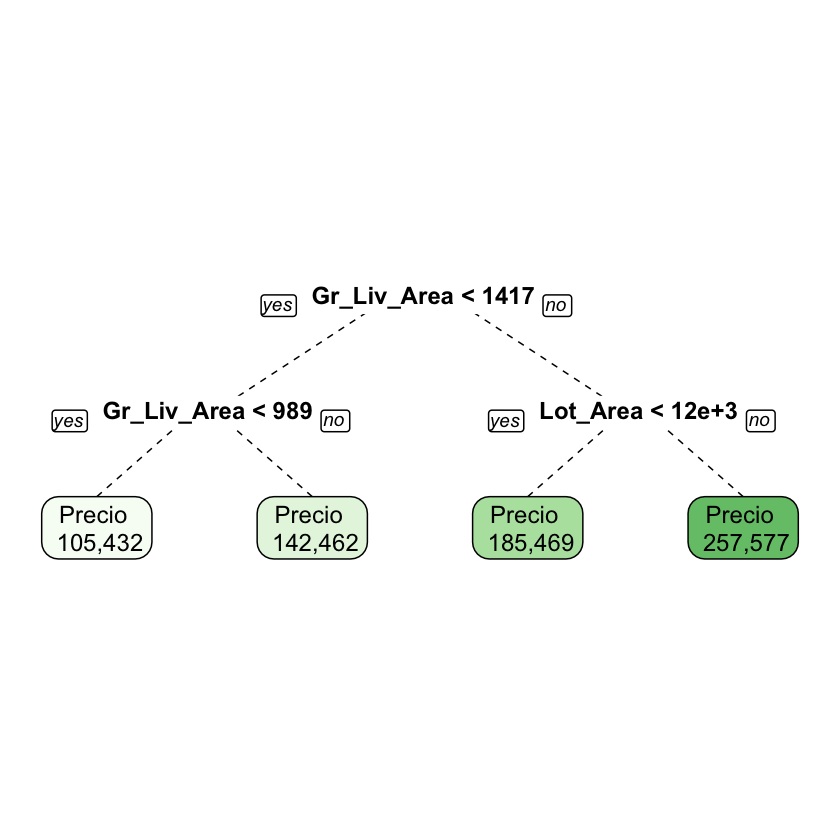

In [40]:
prp(amestree2, 
    under = TRUE, branch.lty = 2, yesno = 2, faclen = 0, varlen = 15, tweak = 1.2,
    clip.facs = TRUE, box.palette = "Greens", compress = FALSE, ycompress = FALSE,
    node.fun = function(x, labs, digits, varlen) 
      paste("Precio \n", format(round(exp(amestree2$frame$yval), 0), nsmall = 0, big.mark = ","))
)


Comparamos el árbol ajustado sobre la muestra bootstrap (`amestree2`) con el árbol original (`amestree`), entrenado sobre el conjunto de datos original. Esta comparación nos permite visualizar cómo el muestreo con reemplazo introduce variabilidad en la estructura del árbol —una idea clave detrás del bagging.

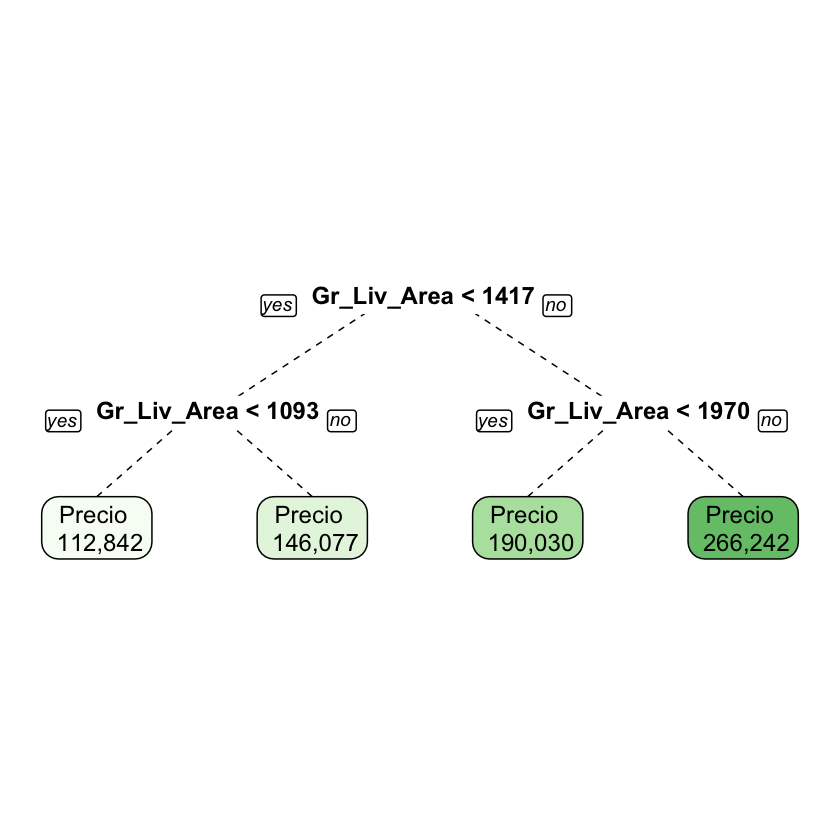

In [41]:
prp(amestree, under = TRUE, branch.lty = 2, yesno = 2, faclen = 0, varlen=15,tweak=1.2,clip.facs= TRUE,box.palette = "Greens",compress=FALSE,ycompress = FALSE,node.fun=function(x, labs, digits, varlen) paste("Precio \n", format(round(exp(amestree$frame$yval), 0), nsmall=0, big.mark=",")))

Como vemos formalmente las predicciones de Bagging?

Formalmente, si denotamos los árboles como funciones:

$$
T_{\text{1}}(x) = \sum_{j=1}^{J_1} \gamma_{j}^{(1)} \cdot \mathbf{1}(x \in R_j^{(1)}), \quad
T_{\text{2}}(x) = \sum_{k=1}^{J_2} \gamma_{k}^{(2)} \cdot \mathbf{1}(x \in R_k^{(2)})
$$

donde cada $ R_j^{(1)} $ y $ R_k^{(2)} $ es una región terminal (una hoja) del árbol correspondiente, y $ \gamma 4 es la predicción constante en esa región.

Entonces, si quisiéramos combinar estos dos árboles, la predicción combinada sería simplemente el promedio:

$
\hat{f}(x) = \frac{1}{2} \left( T_{\text{1}}(x) + T_{\text{2}}(x) \right)
$

En términos prácticos, para cualquier observación \( x \), cada árbol le asigna un valor predicho dependiendo de la región hoja en la que cae, y el modelo final sería el promedio de ambos.


### Con `caret` y `ranger`

Podemos entrenar estos modelos  utilizando el paquete `ranger` en combinación con `caret`, lo cual nos permite buscar automáticamente la mejor combinación de hiperparámetros mediante validación cruzada.


In [42]:
p_load("ranger")
p_load("caret")


`Caret` nos permite ajustar facilmente los siguientes hiperparámetros

- `mtry`: número de predictores seleccionados aleatoriamente en cada división.
- `splitrule`: criterio de división (en regresión, típicamente `"variance"`).
- `min.node.size`: número mínimo de observaciones en un nodo terminal.
- Falta alguno importante?

In [44]:
set.seed(123)  # Fijamos semilla para reproducibilidad

tree_ranger_grid <- train(
    log(Sale_Price) ~ Gr_Liv_Area + Bldg_Type + Fence,  # Fórmula del modelo
    data = ames,  # Dataset de entrenamiento
    method = "ranger",  # Usamos el motor ranger para Random Forests
    trControl = fitControl,  # Especificamos los controles de validación cruzada definidos antes
    tuneGrid = expand.grid(   # Definimos la grilla de hiperparámetros a explorar
        mtry = c(1, 2, 3),  # Número de predictores seleccionados al azar en cada división
        splitrule = "variance",  # Regla de partición basada en la reducción de varianza (regresión)
        min.node.size = c(1, 3, 5)  # Tamaño mínimo de nodos terminales
    ),
    importance = "permutation"  # Calculamos la importancia de variables por permutación
)


In [45]:
tree_ranger_grid

Random Forest 

2930 samples
   3 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 2344, 2345, 2344, 2343, 2344 
Resampling results across tuning parameters:

  mtry  min.node.size  RMSE       Rsquared   MAE      
  1     1              0.3468688  0.4652012  0.2565061
  1     3              0.3451265  0.4674624  0.2549682
  1     5              0.3444146  0.4687882  0.2544363
  2     1              0.2952702  0.5536234  0.2152427
  2     3              0.2956889  0.5538360  0.2154844
  2     5              0.2949705  0.5523762  0.2147375
  3     1              0.2671978  0.5928475  0.1949658
  3     3              0.2686117  0.5911269  0.1957694
  3     5              0.2681990  0.5921731  0.1954628

Tuning parameter 'splitrule' was held constant at a value of variance
RMSE was used to select the optimal model using the smallest value.
The final values used for the model were mtry = 3, splitrule = variance
 and min.node.size = 1.

Una vez entrenado el modelo, podemos examinar qué tan importantes fueron las variables explicativas en las decisiones del Random Forest. Esto nos da una idea de qué características influyen más en la predicción del precio de las viviendas.

In [46]:
varImp(tree_ranger_grid)

ranger variable importance

                        Overall
Gr_Liv_Area            100.0000
Bldg_TypeDuplex          4.7947
Bldg_TypeTwoFmCon        3.2234
FenceNo_Fence            2.8830
Bldg_TypeTwnhsE          2.1580
FenceMinimum_Privacy     2.1104
Bldg_TypeTwnhs           1.2831
FenceGood_Wood           0.3994
FenceMinimum_Wood_Wire   0.0000